# Spacial distribution / anonymization

## Imports and config

In [1]:
import io
import math
import os

import folium
import geojson
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image

In [2]:
# Change directory to scripts folder
directory = os.getcwd().split('/')[-1]

if directory == 'notebooks':
    %cd ..

/home/nicklas/repos/gecco-2023-ambulance-allocation/scripts


In [3]:
# Matplotlib setup
import matplotlib

# matplotlib.use('PDF')

import matplotlib.pyplot as plt
print(f'matplotlib backend: {matplotlib.get_backend()}')

matplotlib backend: module://matplotlib_inline.backend_inline


In [4]:
# configuration variables
should_save = False

## Load

In [5]:
fields = ['tidspunkt', 'xcoor', 'ycoor', 'hastegrad', 'ssbid1000M']
incidents = pd.read_csv('proprietary_data/cleaned_data.csv', usecols=fields)
incidents

,hastegrad,tidspunkt,ssbid1000M,xcoor,ycoor
0,A,2015-02-13 09:23:18,22640006631000,264500,6631500
1,A,2015-02-13 14:01:29,22420006641000,242500,6641500
2,V1,2015-02-13 13:35:14,22650006640000,265500,6640500
3,H,2015-02-13 05:09:00,22640006652000,264500,6652500
4,V1,2015-02-13 16:00:39,22530006621000,253500,6621500
...,...,...,...,...,...
754806,V1,2016-12-14 11:00:00,22690006570000,269500,6570500
754807,V2,2017-12-15 09:00:00,23050006671000,305500,6671500
754808,V2,2016-11-03 08:00:00,22830006611000,283500,6611500
754809,V2,2017-10-18 07:00:00,22680006645000,268500,6645500


## Filter out cells outside of Oslo and Akershus

In [6]:
oslo = pd.read_csv('data/oslo.csv', encoding='utf-8', index_col=4)
akershus = pd.read_csv('data/akershus.csv', encoding='utf-8', index_col=4)
oslo_and_akershus_data = pd.concat([oslo, akershus])

# Create indices based on SSB grids
oslo_and_akershus = oslo_and_akershus_data.index
incidents_cells = pd.Index(incidents['ssbid1000M'])

# Print useful stats
print('Oslo and Akershus cell count:', oslo_and_akershus.shape[0])
print('Total cell count in dataset:', incidents_cells.unique().shape[0])
print('Cells in dataset in Oslo and Akershus:', incidents_cells.unique().isin(oslo_and_akershus).sum())
print('Empty cells in Oslo and Akershus:', oslo_and_akershus.shape[0] - incidents_cells.unique().isin(oslo_and_akershus).sum())

initial_row_count = incidents.shape[0]
print('Initial row count:', initial_row_count)

# Filter out all incident cells that are not located in Oslo and Akershus
incidents = incidents[incidents_cells.isin(oslo_and_akershus)]

rows_remaining = incidents.shape[0]
print(f'Rows remaining: {rows_remaining}')

rows_removed = initial_row_count - rows_remaining
print(f'Rows removed: {rows_removed}')

Oslo and Akershus cell count: 5569
Total cell count in dataset: 5089
Cells in dataset in Oslo and Akershus: 2606
Empty cells in Oslo and Akershus: 2963
Initial row count: 754811
Rows remaining: 585374
Rows removed: 169437


In [7]:
spacial = incidents[['xcoor', 'ycoor', 'ssbid1000M']]
spacial

,xcoor,ycoor,ssbid1000M
0,264500,6631500,22640006631000
1,242500,6641500,22420006641000
2,265500,6640500,22650006640000
3,264500,6652500,22640006652000
4,253500,6621500,22530006621000
...,...,...,...
754801,264500,6643500,22640006643000
754805,269500,6652500,22690006652000
754807,305500,6671500,23050006671000
754809,268500,6645500,22680006645000


## Create distribution and resample data

In [8]:
distribution = spacial['ssbid1000M'].value_counts() / len(spacial)
print(f'Sum: {distribution.sum()}')
distribution

Sum: 1.0


22620006649000    0.085200
22760006650000    0.029545
22600006653000    0.026207
22480006648000    0.018057
22620006651000    0.016760
                    ...   
22880006679000    0.000002
23000006631000    0.000002
22690006617000    0.000002
23060006624000    0.000002
22610006632000    0.000002
Name: ssbid1000M, Length: 2606, dtype: float64

In [78]:
resampled = np.random.choice(distribution.index, p=distribution, size=len(spacial))
resampled = pd.Series(resampled)
resampled_distribution = resampled.value_counts() / len(resampled)
resampled_distribution

22620006649000    0.085234
22760006650000    0.029250
22600006653000    0.026192
22480006648000    0.018028
22620006651000    0.016878
                    ...   
22720006620000    0.000002
22540006635000    0.000002
23060006683000    0.000002
22570006623000    0.000002
22560006616000    0.000002
Length: 2511, dtype: float64

In [80]:
# TODO: add missing IDs with zero probability to compare 
resampled_distribution.isin(resampled).value_counts()

True     2263
False     343
Name: ssbid1000M, dtype: int64

### Check similarity of distributions

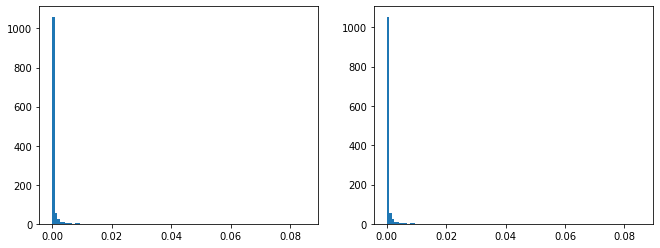

In [56]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(11, 4))
ax1.hist(distribution, bins=100, density=True)
ax2.hist(resampled_distribution, bins=100, density=True);

In [57]:
# Information entropy
def kl_divergence(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

In [62]:
kl_divergence(distribution.values, resampled_distribution.values)

ValueError: operands could not be broadcast together with shapes (2606,) (2490,) 

### Join resampled with incidents 

In [ ]:
# TODO

## Visualize as heatmap

In [10]:
counts = incidents.groupby(['xcoor', 'ycoor'], as_index=False).size()
counts['counts'] = counts['size']
counts.drop(['size'], axis=1, inplace=True)

empty_cells = pd.read_csv('data/empty_cells.csv', encoding='utf-8', index_col=0)
empty_cells = empty_cells[['X', 'Y']].rename(columns={'X': 'xcoor', 'Y': 'ycoor'})
counts = pd.concat([counts, empty_cells.assign(counts=0)]) 

counts.sort_values('counts')

,xcoor,ycoor,counts
22630006667000,263500.0,6667500.0,0
22730006666000,273500.0,6666500.0,0
22720006666000,272500.0,6666500.0,0
22690006666000,269500.0,6666500.0,0
22670006666000,267500.0,6666500.0,0
...,...,...,...
621,262500.0,6651500.0,9811
123,248500.0,6648500.0,10570
546,260500.0,6653500.0,15341
1108,276500.0,6650500.0,17295
